In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def heston_vol_path(v0, kappa, theta, sigma, rho, T, N, dt, num_paths=10):
    vol_paths = np.zeros((num_paths, N))
    for p in range(num_paths):
        vol_paths[p, 0] = v0              
        dW1 = np.random.normal(0, np.sqrt(dt), N-1)
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), N-1)
        for t in range(1, N):
            vol_paths[p, t] = vol_paths[p, t-1] + kappa * (theta - vol_paths[p, t-1]) * dt + sigma * np.sqrt(max(vol_paths[p, t-1], 0)) * dW2[t-1]
            vol_paths[p, t] = max(vol_paths[p, t], 0)
    return np.mean(vol_paths, axis=0)  # Monte Carlo Sim Mean

In [3]:
ticker = "TSLA"
data = yf.download(ticker, start="2019-01-01", end="2024-12-31")
data = data[["Close"]].rename(columns={"Close": "Price"})

start_date = data.index.min().strftime("%Y-%m-%d")
end_date = data.index.max().strftime("%Y-%m-%d")

C:\Users\Tarun\AppData\Local\Temp\ipykernel_80300\1708233384.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


C:\Users\Tarun\AppData\Local\Temp\ipykernel_80300\3363224231.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_paths[p, 0] = v0
C:\Users\Tarun\AppData\Local\Temp\ipykernel_80300\3363224231.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_paths[p, t] = vol_paths[p, t-1] + kappa * (theta - vol_paths[p, t-1]) * dt + sigma * np.sqrt(max(vol_paths[p, t-1], 0)) * dW2[t-1]


Vol Sim Mean: 0.0041, Max: 0.0100, % above 0.05: 0.00%


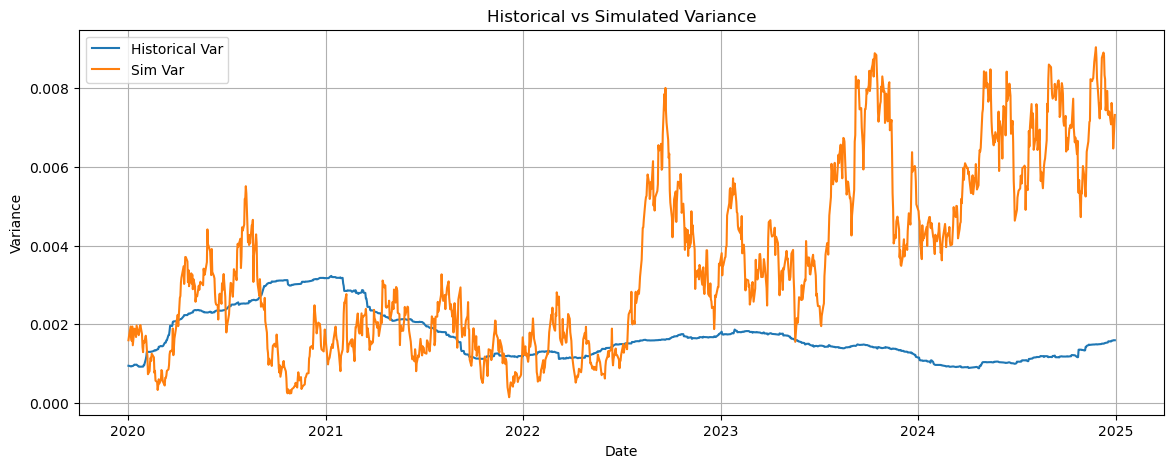

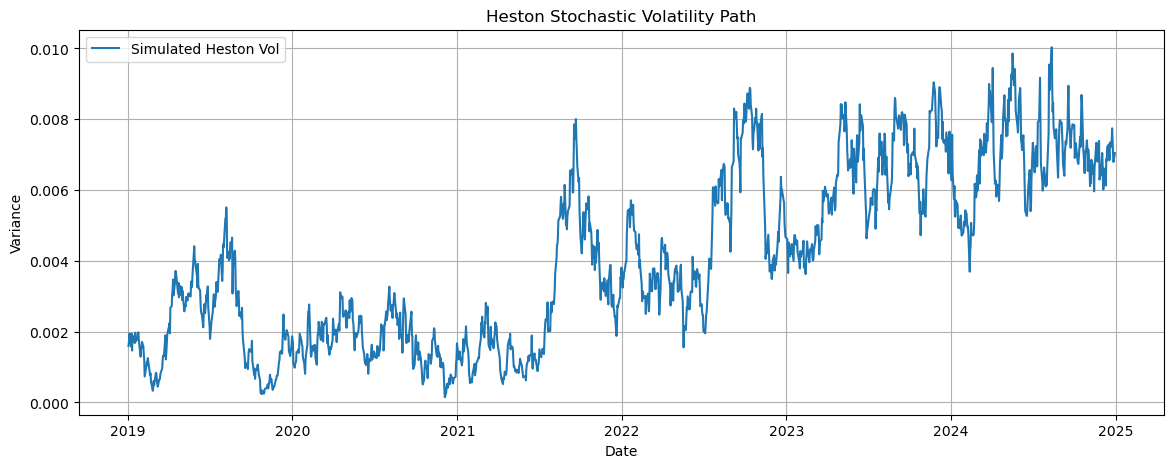

In [4]:
historical_returns = data['Price'].pct_change().dropna()
historical_var = historical_returns.rolling(252).var().dropna()

kappa = 1.5
theta = historical_var.mean()  # Use data-fit; remove constant overwrite
sigma = historical_returns.std() * np.sqrt(252) * 0.5
rho = -0.6
v0 = historical_var.iloc[-1] if not historical_var.empty else 0.04
T = 1.0
N = len(data)
dt = 1 / 252

vol_sim = heston_vol_path(v0, kappa, theta, sigma, rho, T, N, dt, num_paths=10) 

print(f"Vol Sim Mean: {vol_sim.mean():.4f}, Max: {vol_sim.max():.4f}, % above 0.05: {np.mean(vol_sim > 0.05) * 100:.2f}%")

plt.figure(figsize=(14, 5))
plt.plot(historical_var.index, historical_var.squeeze(), label="Historical Var")  # Squeeze to 1D, use own index
plt.plot(historical_var.index, vol_sim[:len(historical_var)], label="Sim Var")  # Slice vol_sim to match length
plt.title("Historical vs Simulated Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(data.index, vol_sim, label="Simulated Heston Vol")
plt.title("Heston Stochastic Volatility Path")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Tarun\AppData\Local\Temp\ipykernel_80300\3363224231.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_paths[p, 0] = v0


Fitted: kappa=1.50, theta=0.0200, sigma=0.80, rho=-0.70, Error = 0.0017
Vol Sim Mean: 0.0240, Max: 0.0498, % above 0.05: 0.00%


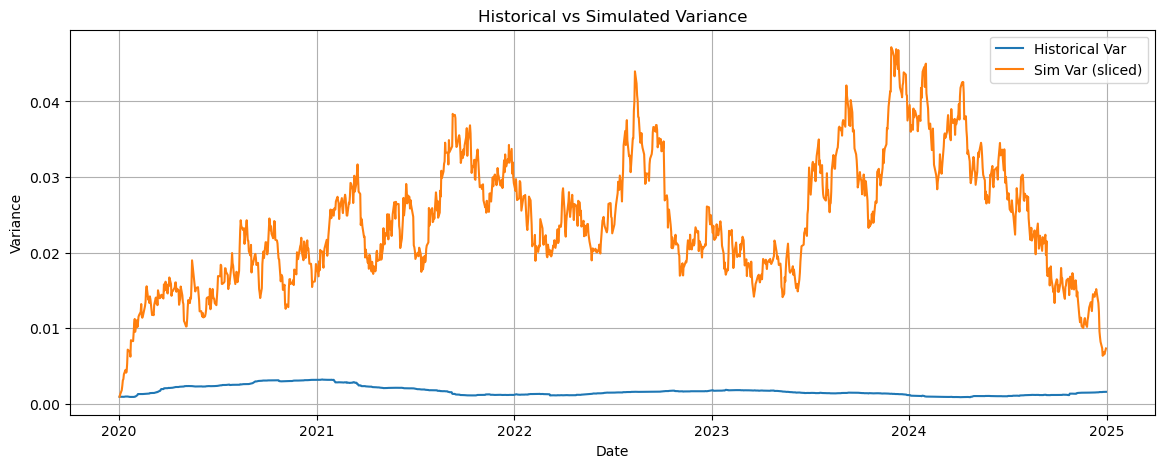

In [5]:
from scipy.optimize import minimize

historical_returns = data['Price'].pct_change().dropna()
historical_var = historical_returns.rolling(252).var().dropna()

def heston_fit_error(params, historical_var):
    kappa, theta, sigma, rho = params
    v0 = historical_var.iloc[0]
    T = 1.0
    N = len(historical_var)
    dt = 1 / 252
    
    sim_var = heston_vol_path(v0, kappa, theta, sigma, rho, T, N, dt, num_paths=20)  
    error = np.mean((sim_var - historical_var.values)**2) 
    vol_penalty = 0.25 * (historical_var.std() - np.std(sim_var))**2
    mean_penalty = 0.25 * (historical_var.mean() - sim_var.mean())**2 #added to penalize high mean
    
    return error + vol_penalty + mean_penalty


initial_params = [1.5, historical_var.mean().item(), 0.8, -0.7]
bounds = [(0.5, 3.0), (0.02, 0.15), (0.4, 1.5), (-0.9, -0.5)] 
result = minimize(heston_fit_error, initial_params, args=(historical_var,), bounds=bounds, method='L-BFGS-B')
kappa, theta, sigma, rho = result.x
print(f"Fitted: kappa={kappa:.2f}, theta={theta:.4f}, sigma={sigma:.2f}, rho={rho:.2f}, Error = {result.fun:.4f}")

#simulating over full data length with fitted params
N_full = len(data)
dt_full = 1 / 252
T_full = N_full * dt_full
v0_full = historical_var.iloc[0] if not historical_var.empty else 0.04
vol_sim = heston_vol_path(v0_full, kappa, theta, sigma, rho, T_full, N_full, dt_full, num_paths=30)

#diagnostics for debugging
print(f"Vol Sim Mean: {vol_sim.mean():.4f}, Max: {vol_sim.max():.4f}, % above 0.05: {np.mean(vol_sim > 0.05) * 100:.2f}%")

plt.figure(figsize=(14, 5))
plt.plot(historical_var.index, historical_var.squeeze(), label="Historical Var")
plt.plot(data.index[-len(historical_var):], vol_sim[:len(historical_var)], label="Sim Var (sliced)")
plt.title("Historical vs Simulated Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
vol_threshold = 0.05

def evaluate_strat(data, short, long):
    sig = signals(data, short, long)
    sig["Return"] = sig["Price"].pct_change()    
    sig['Signal'] = np.where(vol_sim[:len(sig)] > vol_threshold, 0, sig['Signal'])
    sig["Strategy Returns"] = sig["Return"] * sig["Signal"].shift(1)



    cum_return = (1 + sig["Strategy Returns"]).cumprod().iloc[-1]

    sharpe = (
    sig["Strategy Returns"].mean() / sig["Strategy Returns"].std()
    ) * (252 ** 0.5)

    return cum_return, sharpe



In [7]:
def signals(data, short=15, long=40):  # 20 days for short term moving average, 50 for long term
    signals = data.copy()  # copy data to prevent modifying original directly
    signals["ShortMA"] = data["Price"].rolling(window=short).mean()
    signals["LongMA"] = data["Price"].rolling(window=long).mean()

    signals["Signal"] = 0  # initializes column 'Signal' to indicate Buy (1), Hold (0), or Sell (-1)
    signals.loc[signals.index[short:], "Signal"] = (
    (signals["ShortMA"].iloc[short:] > signals["LongMA"].iloc[short:]).astype(int)
    )  # Implementing Logic to derive appropriate signal

    signals["Position"] = signals["Signal"].diff()  # +1 = buy, 0 = hold, -1 = sell
    return signals

In [8]:
#testing short from 5 to 30 and long from 40 to 200
results = []
for short in range(5, 31, 5):
    for long in range(40, 201, 10):
        if short >= long:
            continue #short must be lesser than long

        cumulative, sharpe = evaluate_strat(data, short, long)
        results.append({
            "Short MA": short,
            "Long MA": long,
            "Cumulative Return": cumulative,
            "Sharpe Ratio": sharpe
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Sharpe Ratio", ascending=False)

best_ma = results_df.iloc[0]
best_short = int(best_ma["Short MA"])
best_long = int(best_ma["Long MA"])

In [9]:
def stop_loss(signal_df, stop_loss_pct = 0.05):  #applying stop-loss to make our strategy better
    df = signal_df.copy()
    in_position = False
    entry_price = 0

    for i in range(1, len(df)):
        if df["Position"].iloc[i] == 1:
            in_position = True
            entry_price = (df["Price"].iloc[i]).item()

        elif in_position:
            current_price = (df["Price"].iloc[i]).item()
            drop = (entry_price - current_price) / entry_price

            if drop >= stop_loss_pct:
                in_position = False
                df.at[df.index[i], "Signal"] = 0
                df.at[df.index[i], "Position"] = -1

            elif df["Position"].iloc[i] == -1:
                in_position = False

    return df


In [10]:
stop_results = []

short = 15
long = 40

for stop in [i / 100 for i in range (1, 11)]:
    sig = signals(data, short, long)
    vol_threshold = 0.05
    sig["Signal"] = np.where(vol_sim > vol_threshold, 0, sig["Signal"])
    sig = stop_loss(sig, stop_loss_pct=stop)

    sig["Return"] = sig["Price"].pct_change()
    sig["Strategy Returns"] = sig["Return"] * sig["Signal"].shift(1)


    cumulative = (1 + sig["Strategy Returns"]).cumprod().iloc[-1]

    sharpe = (
        sig["Strategy Returns"].mean() / sig["Strategy Returns"].std()
    ) * (252 ** 0.5)

    stop_results.append({
        "Stop Loss %": f"{int(stop * 100)}%",
        "Cumulative Return": cumulative,
        "Sharpe Ratio": sharpe
    })

stop_df = pd.DataFrame(stop_results)
stop_df["Stop Loss %"] = stop_df["Stop Loss %"].str.replace("%", "").astype(float)
stop_df = stop_df.sort_values(by="Sharpe Ratio", ascending=False)

best_stop = float(stop_df.iloc[0]["Stop Loss %"]) / 100


short = best_short
long = best_long
stop_loss_pct = best_stop

sig_data = signals(data, short=short, long=long)
sig_data["Signal"] = np.where(vol_sim > vol_threshold, 0, sig_data["Signal"])
sig_data = stop_loss(sig_data, stop_loss_pct=stop_loss_pct)

In [11]:

threshold_result = []
for thresh in np.linspace(0.03, 0.07, 5):  
    vol_threshold = thresh
    sig = signals(data, best_short, best_long)
    sig["Signal"] = np.where(vol_sim > vol_threshold, 0, sig["Signal"])
    sig = stop_loss(sig, stop_loss_pct=best_stop)
    sig["Return"] = sig["Price"].pct_change()
    sig["Strategy Returns"] = sig["Return"] * sig["Signal"].shift(1)
    sharpe = (sig["Strategy Returns"].mean() / sig["Strategy Returns"].std()) * np.sqrt(252)
    cum_return = (1 + sig["Strategy Returns"]).cumprod().iloc[-1] - 1
    threshold_result.append({"Threshold": thresh, "Sharpe": sharpe, "Cum Return": cum_return * 100})

threshold_df = pd.DataFrame(threshold_result).sort_values("Sharpe", ascending=False)
print(threshold_df)
best_thresh = threshold_df.iloc[0]["Threshold"]
vol_threshold = best_thresh  # Use this in final sig_data

   Threshold    Sharpe   Cum Return
2       0.05  1.387849  2406.258351
4       0.07  1.387849  2406.258351
3       0.06  1.387849  2406.258351
0       0.03  1.287701  1108.617440
1       0.04  1.221176  1386.065290


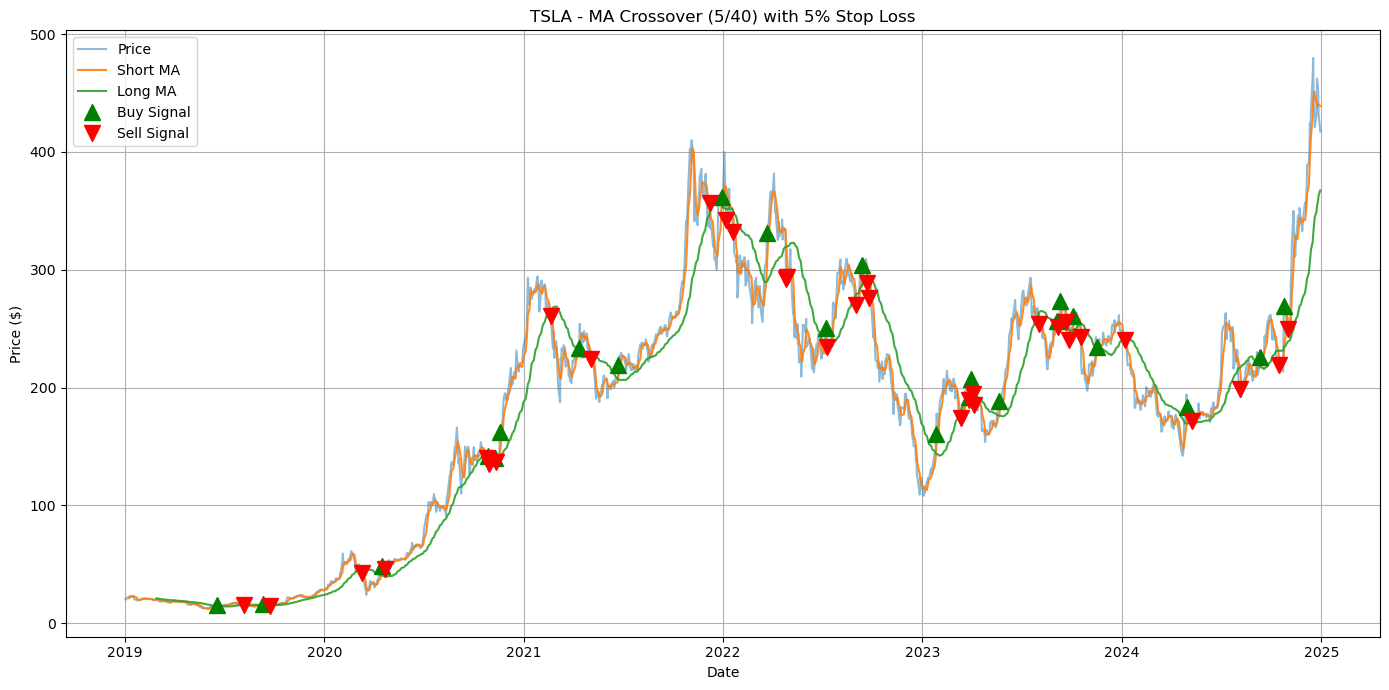

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(sig_data["Price"], label = "Price", alpha=0.5)
plt.plot(sig_data["ShortMA"], label = "Short MA", alpha=0.9)
plt.plot(sig_data["LongMA"], label = "Long MA", alpha=0.9)

#entry markers
plt.plot(sig_data[sig_data["Position"] == 1].index,
         sig_data.loc[sig_data["Position"] == 1, "Price"],
         "^", markersize=12, color="g", label="Buy Signal")

#exit markers
plt.plot(sig_data[sig_data["Position"] == -1].index,
         sig_data.loc[sig_data["Position"] == -1, "Price"],
         "v", markersize=12, color="r", label="Sell Signal")

plt.title(f"{ticker} - MA Crossover ({short}/{long}) with {int(stop_loss_pct * 100)}% Stop Loss")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/final_strategy_graph.png")
plt.show()


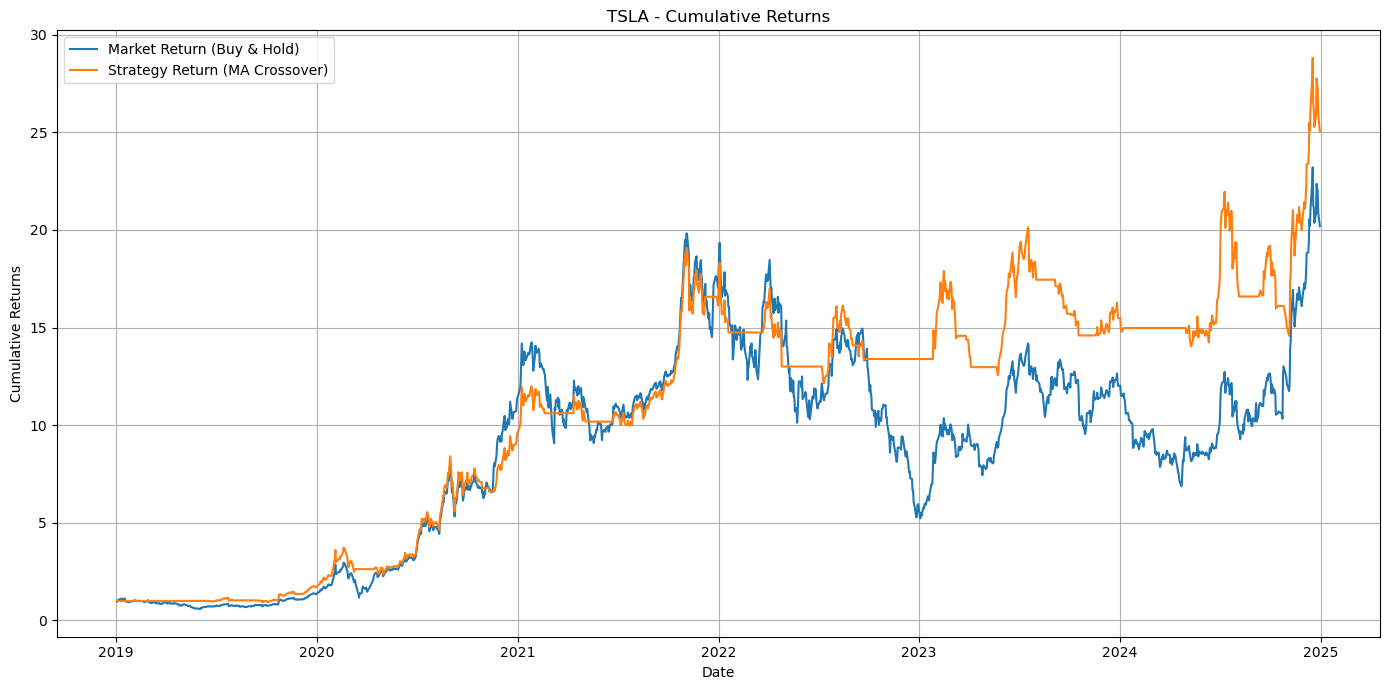

In [13]:
sig_data = signals(data, short=best_short, long=best_long)
sig_data['Signal'] = np.where(vol_sim > vol_threshold, 0, sig_data['Signal'])  
sig_data = stop_loss(sig_data, stop_loss_pct=best_stop)

# rest of your returns, cum returns, plots code
sig_data["Return"] = sig_data["Price"].pct_change()

target_vol = 0.08  
sig["Position Size"] = np.minimum(1.0, target_vol / np.maximum(vol_sim, 0.01))  
sig["Strategy Returns"] = sig["Return"] * sig["Signal"].shift(1) * sig["Position Size"].shift(1)

sig_data["Strategy Returns"] = sig_data["Return"] * sig_data["Signal"].shift(1)  #returns only if we were holding the asset the day before

#cumulative returns calculation
sig_data["Cumulative Market"] = (1 + sig_data["Return"]).cumprod()
sig_data["Cumulative Strategy"] = (1 + sig_data["Strategy Returns"]).cumprod()

#plotting graph for cumulative returns for market buy and hold vs strategy return
plt.figure(figsize=(14, 7))
plt.plot(sig_data["Cumulative Market"], label = "Market Return (Buy & Hold)")
plt.plot(sig_data["Cumulative Strategy"], label = "Strategy Return (MA Crossover)")
plt.title(f"{ticker} - Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/cum_returns.png")
plt.show()

#Calculating Max Drawdown
sig_data["Rolling Max"] = sig_data["Cumulative Strategy"].cummax()
sig_data["Drawdown"] = sig_data["Cumulative Strategy"] / sig_data["Rolling Max"] - 1
max_drawdown = sig_data["Drawdown"].min()



#Calculation of Sharpe Ratio for our strategy
sharpe = (
    sig_data["Strategy Returns"].mean() / sig_data["Strategy Returns"].std()
) * (252**0.5)


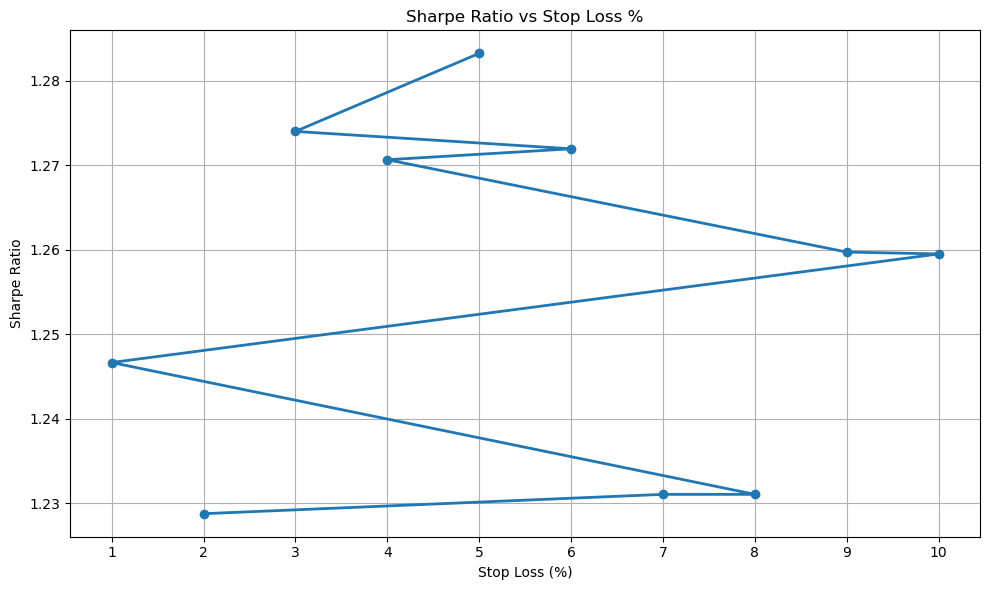

In [14]:
plt.figure(figsize = (10, 6))
plt.plot(stop_df["Stop Loss %"], stop_df["Sharpe Ratio"], marker="o", linestyle="-", linewidth=2)
plt.title("Sharpe Ratio vs Stop Loss %")
plt.xlabel("Stop Loss (%)")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.xticks(stop_df["Stop Loss %"])

plt.tight_layout()
plt.savefig("results/sharpe_vs_stop_loss.png")
plt.show()

#adding trade metrics summary for more information

entry_signals = sig_data[sig_data["Position"] == 1]
exit_signals = sig_data[sig_data["Position"] == -1]

num_trades = len(entry_signals)

wins = 0
trade_returns = []

in_trade = False
entry_price = 0

for i in range (len(sig_data)):
    if sig_data["Position"].iloc[i] == 1:
        entry_price = sig_data["Price"].iloc[i].item()
        in_trade = True

    elif sig_data["Position"].iloc[i] == -1 and in_trade:
        exit_price = sig_data["Price"].iloc[i].item()
        ret = (exit_price - entry_price) / entry_price
        trade_returns.append(ret)
        if ret > 0:
            wins += 1
            in_trade = False

if len(trade_returns) > 0:
    win_rate = wins / len(trade_returns)
    avg_return = sum(trade_returns) / len(trade_returns)
else:
    win_rate = 0
    avg_return = 0


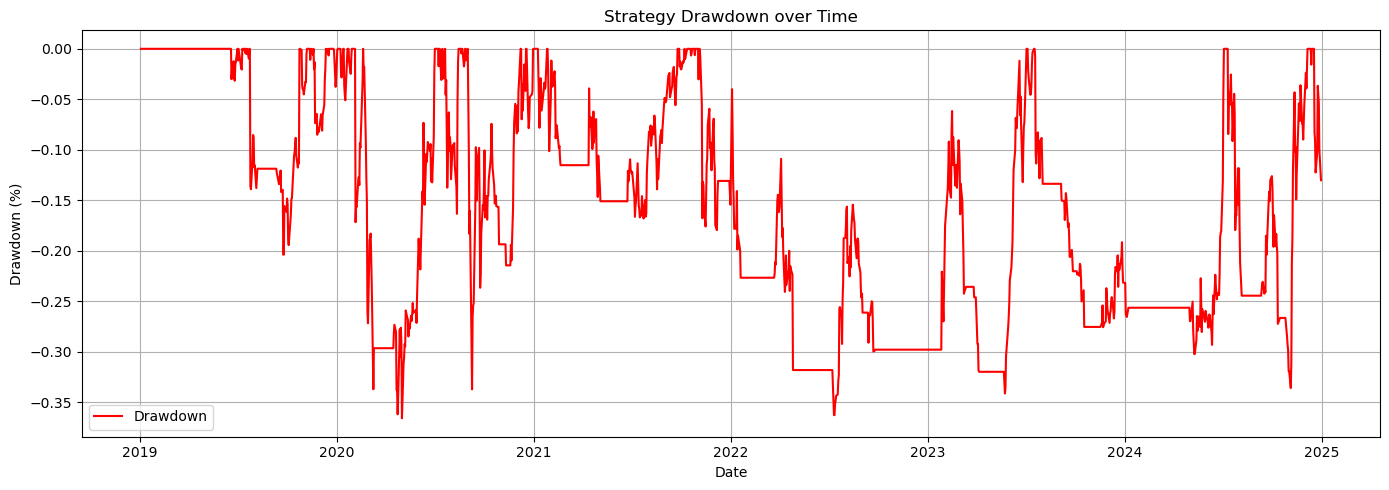

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(sig_data["Drawdown"], color = "red", label = "Drawdown")
plt.title("Strategy Drawdown over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/drawdown_plot.png")
plt.show()

total_return = (sig_data['Cumulative Strategy'].iloc[-1] - 1) * 100
buy_hold_return = (sig_data['Cumulative Market'].iloc[-1] - 1) * 100

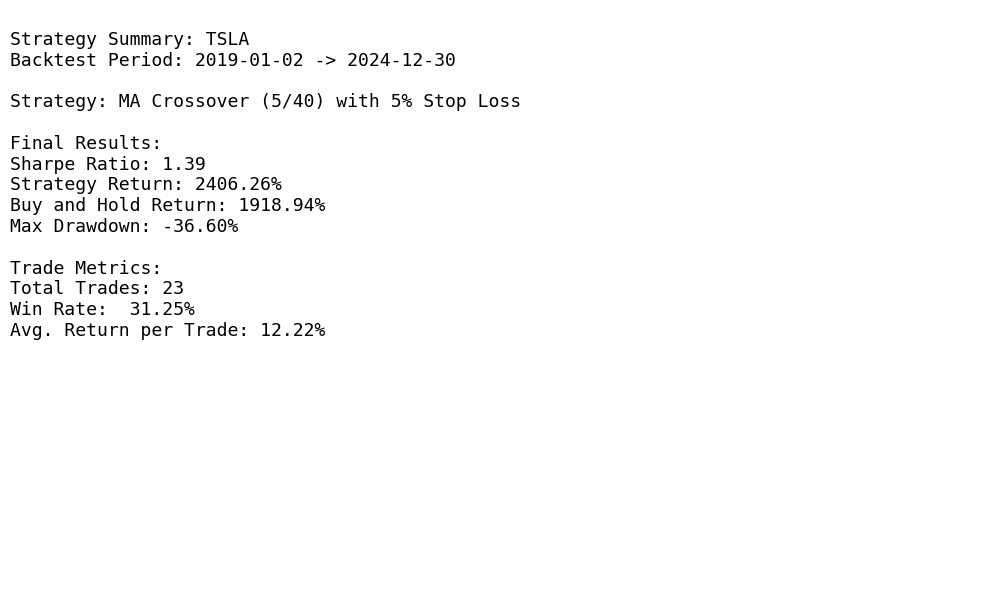

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.axis("off")

text = f"""
Strategy Summary: {ticker}
Backtest Period: {start_date} -> {end_date}

Strategy: MA Crossover ({short}/{long}) with {int(stop_loss_pct * 100)}% Stop Loss

Final Results:
Sharpe Ratio: {sharpe:.2f}
Strategy Return: {total_return:.2f}%
Buy and Hold Return: {buy_hold_return:.2f}%
Max Drawdown: {max_drawdown:.2%}

Trade Metrics:
Total Trades: {num_trades}
Win Rate: {win_rate: .2%}
Avg. Return per Trade: {avg_return:.2%}
"""

ax.text(0, 1, text, fontsize = 13, va="top", ha = "left", family="monospace")

plt.tight_layout()
plt.savefig("results/final_summary_card.png")
plt.show()